In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import glob
from ultralytics import YOLO

### Data 

In [14]:
data_dir = "UTKFace"

In [15]:
data = pd.DataFrame(columns=["image", "age"])

### Create dataframe from images

In [16]:
filenames = []
ages = []
for filename in glob.glob(f"{data_dir}/*.jpg"):
    age = int(filename.split("\\")[1].split("_")[0])
    filenames.append(filename)
    ages.append(age)

data_dict = {}
data_dict['image']=filenames
data_dict['age'] = ages   

data = pd.DataFrame.from_dict(data_dict)

In [6]:
data

,image,age
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9
23704,UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9
23705,UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9
23706,UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9


<Axes: >

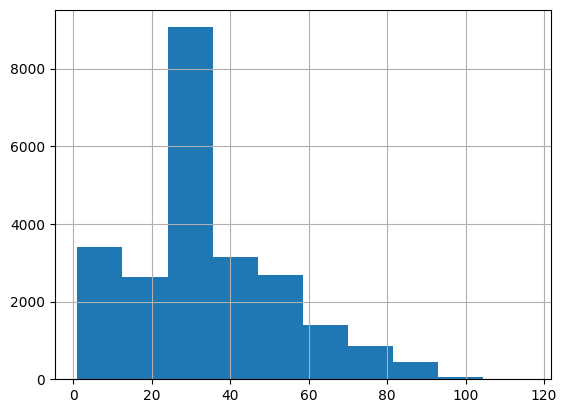

In [20]:
data['age'].hist()

### Devide age into chunks

In [17]:
def age_splitter(age):
    if 0 <= age <= 2:
       return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [18]:
data['target']=data['age'].map(age_splitter)

In [19]:
data

,image,age,target
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,6
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,6
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,6
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,6
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,6
...,...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9,1
23704,UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9,1
23705,UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9,1
23706,UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9,1


In [45]:
data['image']

0        UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1        UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2        UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3        UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4        UTKFace\100_1_0_20170112213303693.jpg.chip.jpg
                              ...                      
23703      UTKFace\9_1_3_20161220222856346.jpg.chip.jpg
23704      UTKFace\9_1_3_20170104222949455.jpg.chip.jpg
23705      UTKFace\9_1_4_20170103200637399.jpg.chip.jpg
23706      UTKFace\9_1_4_20170103200814791.jpg.chip.jpg
23707      UTKFace\9_1_4_20170103213057382.jpg.chip.jpg
Name: image, Length: 23708, dtype: object

### Create dataset and dataloader

In [20]:
class AgeDataset(Dataset):
    """
    AgeDataset
    """
    def __init__(self, df, transform=None):
        self.images = df['image']
        self.age = df['age']    
        self.transform = transform         
           
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
                
        img_name = self.images.iloc[idx]
        
        img = Image.open(img_name).convert("RGB")
        
        target = self.age.iloc[idx]
        target = torch.tensor(target, dtype=torch.float32)
        
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)  
        
        return img, target

In [21]:
#define transform to be applied
transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(40)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [22]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [23]:
train_data['image'].iloc[0]

'UTKFace\\25_0_0_20170117203843296.jpg.chip.jpg'

In [24]:
train_dataset = AgeDataset(train_data, transform=transforms)
val_dataset = AgeDataset(val_data, transform=transforms)

In [25]:
len(train_data)

18966

In [38]:
len(val_data)

4742

In [26]:
BATCH_SIZE = 64

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
images, target = next(iter(train_loader))

In [50]:
images

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [14]:
target

tensor([ 45.,  35.,  23.,  25.,  65.,  19.,  15.,  24.,  51.,   2.,  25.,  26.,
          1.,  38.,  40.,  34.,  55.,  31.,   2.,   3.,  34.,  40.,  17.,  32.,
         21.,  32.,  26.,  16.,   1.,  26.,  17.,  28.,  26.,  36.,  52.,  59.,
         81.,   1.,  23.,  45.,  25.,  47.,  23.,  72.,  30.,  70.,  65.,  32.,
          1.,   3., 116.,  78.,  37.,  32.,  17.,  45.,  28.,  81.,  27.,  35.,
         56.,  22.,  24.,  32.])

### Age model

In [31]:
class AgeModel(nn.Module):
    def __init__(self, out_features):
      super(AgeModel, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) #222
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)) #109
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)) #52
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3)) #24
      self.avgpool2d = nn.AvgPool2d(kernel_size=(2,2))
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.linear1 = nn.Linear(in_features=9216, out_features=128)
      self.linear2 = nn.Linear(in_features=128, out_features=1) 

    def forward(self, input):

      x = self.avgpool2d(self.relu(self.conv1(input)))
      x = self.avgpool2d(self.relu(self.conv2(x)))
      x = self.avgpool2d(self.relu(self.conv3(x)))
      x = self.avgpool2d(self.relu(self.conv4(x)))
      x = nn.Flatten()(x)
      x = self.relu(self.linear1(x))
      x = self.dropout(x)
      x = self.linear2(x)
      
      return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
age_model = AgeModel(out_features=1)

In [24]:
def train(train_loader, val_loader, model, optimizer, loss_fn, epochs, save_path):
    
    min_loss = 100
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()

        model.to(device)
        
        epoch_losses = []
        
               
        for images, targets in train_loader:   

            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            outputs = outputs.squeeze()          
            
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
            
        print(f"Epoch {epoch:d}: Train Loss : {torch.tensor(epoch_losses).mean():.3f}")
                
        train_losses.append(torch.tensor(epoch_losses).mean())       
        
        
        #evaluation mode
        with torch.no_grad():
        
            model.eval()
            
            epoch_losses = []
            
            
            for images, targets in val_loader: 

                images = images.to(device)
                targets = targets.to(device)  
                
                outputs = model(images)
                outputs = outputs.squeeze()
                loss = loss_fn(outputs, targets)
                
                        
                epoch_losses.append(loss.item())
                
                                
        print(f"Epoch {epoch:d}: Val Loss : {torch.tensor(epoch_losses).mean():.3f}")
                
         
        val_losses.append(torch.tensor(epoch_losses).mean()) 
        
        mean_val_loss = torch.tensor(epoch_losses).mean()
        
        if mean_val_loss < min_loss:
            min_loss = mean_val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved")
        
    return train_losses, val_losses

In [25]:
EPOCHS = 100
learning_rate = 1.e-4

In [35]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
train_losses, val_losses = train(train_loader, val_loader,
                                model, optimizer, loss_fn,
                                epochs=EPOCHS, save_path="models/age_model.pt")

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64

AttributeError: 'list' object has no attribute 'mean'

### Face detection model

In [18]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

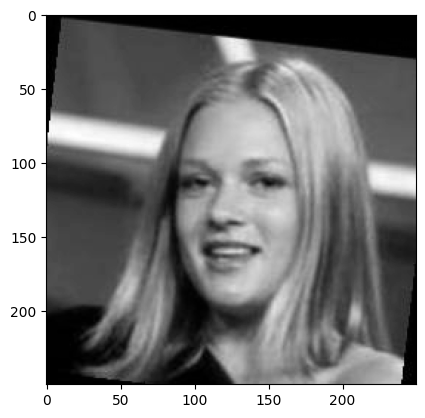

In [38]:
img = cv2.imread("lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

In [29]:
faces = face_classifier.detectMultiScale(
    gray, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20)
)

In [32]:
faces

array([[ 68,  69, 116, 116]])

In [31]:
for face in faces:
    cv2.rectangle(img, face[:2], face[2:], color=(0, 0, 255), thickness=1)

cv2.imshow("result", img)
cv2.waitKey(0)    
cv2.destroyAllWindows()

### Face detection

In [2]:
import face_detection

In [25]:
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
detections = detector.detect(img)

In [27]:
detections

array([[     87.492,      58.165,      173.98,      194.19,     0.99985]], dtype=float32)

In [32]:
def show_face(img, detections):
    img_copy = img.copy()
    
    for face in detections:
        face = list(map(int, face))
        
        cv2.rectangle(img_copy, face[:2], face[2:4], color=(0, 0, 255), thickness=1)

    cv2.imshow("result", img_copy)
    cv2.waitKey(0)    
    cv2.destroyAllWindows()

In [33]:
show_face(img, detections)

### Yolov8 face

In [2]:
face_model=YOLO("face_models/yolov8n-face.pt")

In [6]:
detections = face_model(img)


0: 640x640 1 face, 124.1ms
Speed: 5.0ms preprocess, 124.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


In [23]:
detections[0].boxes.xyxy

tensor([[ 88.1385,  61.1320, 172.0035, 193.6369]])

In [35]:
show_face(img, detections[0].boxes.xyxy)

### Test on videos

In [76]:
age_model = AgeModel(out_features=1)
age_model.load_state_dict(torch.load("age_models/age_model.pt", map_location=torch.device('cpu')))
age_model.eval()

AgeModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (avgpool2d): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=9216, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [66]:
def preprocess_image(img):
    transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
    transformed_img = transforms(img)
    return transformed_img.unsqueeze_(dim=0)

In [57]:
images, target = next(iter(train_loader))

In [61]:
age_model(images[0].unsqueeze_(dim=0))

tensor([[23.0882]], grad_fn=<AddmmBackward0>)

In [67]:
img = cv2.imread("lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg")
transformed_img = preprocess_image(img)
age_model(transformed_img)

tensor([[22.0203]], grad_fn=<AddmmBackward0>)

In [3]:
def draw_predictions(frame, predictions):
    for prediction in predictions:
        prediction = list(map(int, prediction))
        cv2.rectangle(frame, prediction[:2], prediction[2:], color=(0, 255, 0), thickness=2)
        

In [72]:
def draw_age(frame, x, y, age):
    cv2.putText(frame, str(int(age)), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 0.5, color=(0, 255, 0), thickness=2) 

In [74]:
video_file_name = "videos/video1.mp4"

In [6]:
if not os.path.exists("results"):
    os.mkdir("results")

In [77]:
cap = cv2.VideoCapture(video_file_name)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

name = video_file_name.split("/")[1].split(".")[0]

cap_writer = cv2.VideoWriter(f'results/{name}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))


success, frame = cap.read()


while success:

    results = face_model(frame)
    draw_predictions(frame, results[0].boxes.xyxy)
    for face in results[0].boxes.xyxy:
        x1, y1, x2, y2 = list(map(int, face))
        ROI = frame[y1:y2, x1:x2]
        preprocessed_ROI = preprocess_image(ROI)
        age = age_model(preprocessed_ROI)[0].item()
        draw_age(frame, x1, y1, age)
        
    cap_writer.write(frame)
        
    cv2.imshow("img", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
        
    success, frame = cap.read()
 
cap.release()   
cv2.destroyAllWindows()

0: 384x640 6 faces, 80.3ms
Speed: 2.0ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 75.1ms
Speed: 1.6ms preprocess, 75.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 69.9ms
Speed: 2.0ms preprocess, 69.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 66.5ms
Speed: 1.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 67.5ms
Speed: 1.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 67.8ms
Speed: 1.0ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 60.0ms
Speed: 1.0ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 faces, 60.9ms
Speed: 1.0ms preprocess, 60.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

